In [12]:
#%% Libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.integrate import odeint
from scipy.optimize import fsolve
import scipy as sp
#from numba import jit  
#import wallEquations
# Functions



def QLossFunc(heatCoef,Area,Tbuilding,Toutside):
    """Returns the heat loss of spesific item

    Args:
        heatCoef (float): heat transfer coefficient
        Area (float): area of specific item
        Tbuilding (float): temperatur of building 
        Toutside (float): temperature outside

    Returns:
        float: Heat loss from specific item
    """
    return heatCoef*Area*(Tbuilding-Toutside)

def rhoRelative(T, rho0=1.1839, T0=298.15):
    """Returns the density of given T

    Args:
        rho0 (float): density of air at 1atm
        T0 (float): 25 degree celc
        T (float): input temperature

    Returns:
        float: density of input temperature
    """
    return (rho0*T0) / T

def specEnthalpy(T):
    return 30.184e3+10*(2501 + 1.84 * T)
def checkIfNegative(val):
    if val < 0:
        return 0
    return val

class model:
    # Global/Static variable
    qlossWalls = 0
    wallTempLst = []
    QlossRoof = 0
    roofTempLst = []
    QlossFloor = 0
    floorTempLst = []
    Qlossfur = 0
    furTempLst = []
    def __init__(self, airflow=0.7, dt=1, simTime=100, WithFur=False ):
       
        # Time constants
        self.dt = dt
        self.deltaH = 1/self.dt 
        self.simulationTime = 0
        self.simTimeEnd = simTime

        # Building dimentions
        self.l = 3.65 # building length [m]
        self.w = 4 # building width [m]
        self.h = 3.3 # building height [m]

        self.Vb = self.l*self.h*self.w
        self.A = 2*(self.l*self.w) +2*(self.h*self.w) + 2*(self.h*self.l)
        # Other variables
        self.cPB = 1.005e3 # J/kg Specific heat capacity of moist air inside building
        self.R = 8.314472  # Pa m^3/ mol K Gas constant
        self.M_air = 28.97e-3 # [kg/mol] Molar mass of dry air
        self.M_H2O = 18e-3 # [kg/mol] Molar mass of water
        self.vIn = (airflow )/((3600*1)*(self.l*self.w)) #(self.l*self.w)
        self.vOut = self.vIn
        self.eta = 0.7
        self.Cp_dryair=1006
        self.Cp_H2O=1840
        self.h_fg = 2260000
        # Areas 
        self.Awindow = 1.2 # [m^2] Area of window
        self.Adoor = 0.75*2.1 # [m^2] Area of door
        self.Awalls = 2*(self.l+self.w)*self.h - (self.Awindow+self.Adoor) # [m^2] Area of walls
        self.Aroof = self.l*self.w # [m^2] Area of roof
        self.Afloor =  self.l*self.w # [m^2] Area of floor
        self.A = 2*(self.l*self.w) +2*(self.h*self.w) + 2*(self.h*self.l)
        
        # Overall heat transfer coefficients
        self.Uwindow = 1.2 # [W/m^2K] Heat transfer coeff of window
        self.Udoor = 1.2 # [W/m^2K] Heat transfer coeff of door
        self.Uwalls = 0.18 # [W/m^2K] Heat transfer coeff of walls
        self.Uroof = 0.13 # [W/m^2K] Heat transfer coeff of roof
        self.Ufloor =  0.15 # [W/m^2K] Heat transfer coeff of floor
        self.U = 1.2*2+0.18+0.13+0.15

        init_Temp = 0+273.15
        self.TwallInit = [20+init_Temp,init_Temp,init_Temp,init_Temp]
        self.TroofInit = [20+init_Temp,init_Temp,init_Temp,init_Temp]
        self.TfloorInit = [20+init_Temp,init_Temp,init_Temp]
        self.TfurInit = [20+init_Temp]

        self.lastTime = 0
        self.Qwalls = 0
        self.Qroof = 0
        self.Qfloor = 0
        self.Qfur = 0

        # Q gain factors
        self.Qheater = 1000
        self.Qpeople = 0
        self.Qappliances = 0
        self.Qsolar = 0

        # Surface temperature lists
        self.wallSurfaceLst = 0
        self.roofSurfaceLst = 0
        self.floorSurfaceLst = 0
        self.furSurfaceLst = 0

        self.WithFur = WithFur

    def Qdot(self, Tb, time):
        """Returns heat loss and gain of all elements on specific room temperature

        Args:
            Tb (float): Room temperature at given time
        """
        # Heat loss
        self.Qwindow = QLossFunc(self.Uwindow, self.Awindow, Tb, self.Toutside) # W, 
        self.Qdoor = QLossFunc(self.Udoor, self.Adoor, Tb, self.Toutside) # W
        # self.Qwalls = QLossFunc(self.Uwalls, self.Awalls, Tb, self.Toutside) # W
        # self.Qfloor = QLossFunc(self.Ufloor, self.Afloor, Tb, self.Toutside) # W
        # self.Qroof = QLossFunc(self.Uroof, self.Aroof, Tb, self.Toutside) # W
        #hb = 2
        if self.lastTime < time: 
            t = np.arange(self.lastTime, self.lastTime+time)
            if time != 0:
                y0 = self.TwallInit
                y0 = odeint(self.Qloss_walls, y0, t,(self.Awalls, self.Tb, 2 ),rtol=1e-3,atol=1e-3)  
                self.Qwalls = checkIfNegative(model.qlossWalls)
                self.wallSurfaceLst = model.wallTempLst
                self.TwallInit = y0[-1]

                y02 = self.TroofInit
                y02 = odeint(self.Qloss_roof, y02, t,(self.Aroof, self.Tb, 2 ),rtol=1e-3,atol=1e-3)  
                self.Qroof = checkIfNegative(model.QlossRoof)
                self.roofSurfaceLst = model.roofTempLst
                self.TroofInit = y02[-1]
                
                y03 = self.TfloorInit
                y03 = odeint(self.Qloss_floor, y03, t,(self.Afloor, self.Tb, 2 ),rtol=1e-3,atol=1e-3)  
                self.Qfloor = checkIfNegative(model.QlossFloor)
                self.floorSurfaceLst = model.floorTempLst
                self.TfloorInit = y03[-1]

                if self.WithFur:
                  y04 = self.TfurInit
                  y04 = odeint(self.Qloss_furniture, y04, t,(0, self.Tb, 2 ),rtol=1e-3,atol=1e-3)  
                  self.Qfur = checkIfNegative(model.Qlossfur)
                  self.furSurfaceLst = model.furTempLst
                  self.TfurInit = y04[-1]
                

        self.Qloss = self.Qwindow + self.Qdoor + self.Qwalls + self.Qroof + self.Qfloor + self.Qfur
        
        # if time >= 49*60*60 and time <= 50*60*60:
        #     print("Tb", self.Tb)
        #     print("Qfur", self.Qfur)
        #     print("Qloss", self.Qloss)
        #     print("print(self.TfurInit)", self.TfurInit)
        self.lastTime = time

        if (time >= 50*60*60):
            self.Qheater = 0
        else:
            self.Qheater = 1000

        self.Qgain = self.Qheater + self.Qpeople + self.Qappliances + self.Qsolar
        self.Q = self.Qgain - self.Qloss
    
    def buildingModel(self, Tb, t, Toutside):
        self.Tb = Tb
        self.Toutside = Toutside
        
        rhoIn = self.rhoInFunc(self.Toutside)
        self.rhoIn = rhoIn
        rhoB = rhoRelative(self.Tb)
        self.rhoB = rhoB
        self.hIn, self.hOut  = self.h_Air()

        self.Qdot(self.Tb, t)
        dydt=self.dTbdt()
        return dydt


    def dTbdt(self):
        """Returns tempature of the room 
        
        """   
        #ventilation = (self.vIn*self.rhoIn*self.hIn - self.vOut*self.rhoB*self.hOut)
        deltaRhoB = (self.vIn*self.rhoIn-self.vOut*self.rhoB) / self.Vb

        firstPart = (self.vIn*self.rhoIn*self.hIn - self.vOut*self.rhoB*self.hOut + self.Q) / (self.Vb*self.rhoB*(self.Cp_air-(self.R/self.Mb))) - (self.Tb/self.rhoB)*deltaRhoB
        #secondPart = (self.Tb/self.rhoB)*deltaRhoB
        return firstPart

    def sumOfAnU(self):
        Ulst = np.array([self.Udoor,self.Uroof, self.Uwalls, self.Uwindow, self.Ufloor])
        Alst = np.array([self.Adoor, self.Aroof, self.Awalls, self.Awindow, self.Afloor])
        return np.sum(Ulst)*np.sum(Alst)
    def analytical(self,t,k1Init=10, k2=0.2,T0=20,tf=50, Toutside=-2.2, T0Change=52.5, realValues=False):
        if realValues:
            f = list()
            Tb = T0
            self.Tb = Tb
            print(Toutside)
            self.Toutside = Toutside
            self.Mb = 28.97e-3

            #self.hIn = specEnthalpy(Tb)   # J/kg Specific enthalpy of incoming air to the x direction, valgt
            #self.hOut = specEnthalpy(self.Toutside) # J/kg Specific enthalpy of outgoing air to the x direction, valgt
            
            self.Qdot(Tb,0)
            Qgain = 1000
            rhoIn = 1.1041 #self.rhoInFunc(self.Toutside)
            self.rhoB = 1.1041 #rhoRelative(Tb)
            self.hIn = 30.184e3+10*(2501 + 1.84 * Toutside) #self.h_Air()
            self.hOut = 30.184e3+10*(2501 + 1.84 * Tb) #self.h_AirPutFunc(rhoIn)     

            ToutSum = self.Toutside*self.sumOfAnU()
            k1=self.vIn*rhoIn*self.hIn - self.vOut*self.rhoB*self.hOut # k1 = (self.vIn*rhoIn*self.hIn-self.vOut*self.rhoB*self.hOut + Qgain +ToutSum ) / (self.rhoB*self.Vb*(self.cPB-(self.R/self.Mb)))
            k1+= Qgain
            k1+= self.Toutside*self.sumOfAnU()
            k1 = k1/(self.Vb*self.rhoB*(self.cPB-self.R/self.Mb))
            k2 = self.sumOfAnU()/(self.Vb*self.rhoB*(self.cPB-self.R/self.Mb)) + (self.vIn*rhoIn-self.vOut*self.rhoB)/self.Vb*self.rhoB
            k2 = k1/T0Change
            #k2 = (self.sumOfAnU() + (self.rhoB*self.Vb*(self.cPB-(self.R/self.Mb)))) + ((self.vIn*rhoIn - self.vOut*self.rhoB) / (self.rhoB*self.Vb))
            print("k1", k1)
            print("k2", k2)
            
            f = self.T(t[t<=tf],k1=k1,k2=k2, T0=Tb)
            self.rhoB = 1.1041 #rhoRelative(T0Change)
            self.hIn = 30.184e3+10*(2501 + 1.84 * Toutside) #self.h_Air()
            self.hOut = 30.184e3+10*(2501 + 1.84 * T0Change) #self.h_AirPutFunc(rhoIn)     

            
            #self.Qdot(T0Change, tf)
            Qgain = 0
            ToutSum = self.Toutside*self.sumOfAnU()
            k1=self.vIn*rhoIn*self.hIn - self.vOut*self.rhoB*self.hOut # k1 = (self.vIn*rhoIn*self.hIn-self.vOut*self.rhoB*self.hOut + Qgain +ToutSum ) / (self.rhoB*self.Vb*(self.cPB-(self.R/self.Mb)))
            k1+= Qgain
            k1+= self.Toutside*self.sumOfAnU()
            k1 = k1/(self.Vb*self.rhoB*(self.cPB-self.R/self.Mb))
            k2 = self.sumOfAnU()/(self.Vb*self.rhoB*(self.cPB-self.R/self.Mb)) + (self.vIn*rhoIn-self.vOut*self.rhoB)/self.Vb*self.rhoB
            #k2 = (self.sumOfAnU() + (self.rhoB*self.Vb*(self.cPB-(self.R/self.Mb)))) + ((self.vIn*rhoIn - self.vOut*self.rhoB) / (self.rhoB*self.Vb))
            print("k1", k1)
            print("k2", k2)
            
            f = np.append(f,self.T(t[t>tf]-tf,k1=k1,k2=k2, T0=T0Change))
     
            return np.array(f)
        else:
            k1 = np.ones(len(t))*k1Init
            k2=k1Init/T0Change
            k1[t>tf] = 0.386

            f=self.T(t[t<=tf],k1=k1[t<=tf],k2=k2,T0=T0)

            f=np.append(f,self.T(t[t>tf]-tf,k1=k1[t>tf],k2=k2,T0=T0Change))

            return f
    def T(self, t,k1=5,k2=.1,T0=20):
        return 1/k2*(k1-(k1-k2*T0)*np.exp(-k2*t))

    def rhoInFunc(self, Toutside, RH_out=0.77, P=101325):
        #Coefficients to determine the saturation vapor pressure of water
        p1=5.2623e-09
        p2=-6.3323e-06
        p3=0.003072
        p4=-0.75032
        p5=92.195
        p6=-4556.2
        p7=91.59
    
        Psat = p1*pow(Toutside,6) + p2*pow(Toutside,5) + p3*pow(Toutside,4) + p4*pow(Toutside,3) + p5*pow(Toutside,2) + p6*Toutside + p7

        PH2O = RH_out*Psat              # [Pa] Vapor presure of water at considering temperature and pressure
        f_H2O_in = PH2O/P          # [moles of water vapor/moles of moist air] Molar fraction of water vapor in
        self.f_H2O_in = f_H2O_in

        M_in = self.M_air*(1-f_H2O_in) + self.M_H2O*f_H2O_in      # [kg/mol] Molar mass of incoming moist air
        Rho_in = P*M_in/(self.R*Toutside)   # [kg/m3] Density of inlet air
        return Rho_in

    def h_Air(self):
        """ Return specific enthalpy of incoming air
        """
        self.xi=self.f_H2O_in*self.M_H2O/(1-self.f_H2O_in)/self.M_air
        h_dryair=self.Cp_dryair*self.Toutside
        h_H2O=self.Cp_H2O*self.Toutside+self.h_fg
        h_air_in=h_dryair+self.xi*h_H2O

        xo=self.vIn*self.rhoIn*self.xi/(self.vOut*self.rhoB)

        h_air_out=self.Cp_dryair*self.Tb+xo*(self.Cp_H2O*self.Tb+self.h_fg)      
        self.Cp_air=self.Cp_dryair+self.Cp_H2O*xo

        f_H2O_out = (xo/self.M_H2O)/(xo/self.M_H2O+(1-xo)/self.M_air)
        M_out = self.M_air*(1-f_H2O_out) + self.M_H2O*f_H2O_out
        self.Mb = M_out

        return h_air_in, h_air_out
   
    def Qloss_walls(self, X, t, A,Tb, hb, Toutside=-2.2+273.15, change = 1, fsolveTol = 0.01):
        T1, T2, T3, T4 = X  # temperatures of wall layers

        hInf = 1#self.hIn #30.184e3+10*(2501 + 1.84 * Toutside)
        # Constants
        a1 = 1.7e-7*change
        a2 = 1.4e-6*change
        a3 = 2.25e-2*change
        a4 = 1.7e-7*change

        l1 = 6e-3
        l2 = 75e-3
        l3 = 8.5e-3
        l4 = 8.5e-3

        K1 = 0.14
        K2 = 0.038
        K3 = 0.026
        K4 = 0.14

        def surfaceTemp(ki,ki2,li,li2,Ti,Ti2):
            return ((ki/li)*Ti + (ki2/li2)*Ti2) / ((ki/li) + (ki2/li2))

        # Inner surface temperatures are currently computed as arithmetic
        # averages of the layer temperatures:
        T2_s = surfaceTemp(K1,K2,l1,l2,T1,T2) #0.5*(T1+T2)
        T3_s = surfaceTemp(K2,K3,l2,l3,T2,T3) #0.5*(T2+T3)
        T4_s = surfaceTemp(K3,K4,l3,l4,T3,T4) #0.5*(T3+T4)

        # Find temperatures of internal and external boundaries:
        def internalEquation(T_surface):
            return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1
        
        def externalEquation(T_surface):
            sigma = sp.constants.Stefan_Boltzmann
            eps = 0.8
            return hInf*A*(T_surface-Toutside) + sigma*eps*(T_surface**4 - Toutside**4) \
                                            - 0.5*K4*A*(T4_s - T_surface)/l4

        T1_s = fsolve(internalEquation, T2_s, xtol=fsolveTol)
        T5_s = fsolve(externalEquation, T4_s, xtol=fsolveTol)
        
        # Differential equations for wall layers:

        rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2
        rhs2 = a2*(T3_s - 2*T2 + T2_s)/l2**2
        rhs3 = a3*(T4_s - 2*T3 + T3_s)/l3**2
        rhs4 = a4*(T5_s - 2*T4 + T4_s)/l4**2

        # Calculate Qloss
        model.wallTempLst.append(T1_s[-1])
        model.qlossWalls = hb*A*(Tb-T1_s[-1]) # varme tap, NB! byttet TB og T1_s!!!!
        #print("self.Qwalls inside",self.Qwalls)
        #print(self.Qwalls)
        #print("t",t)
        return [rhs1, rhs2, rhs3, rhs4]
    def Qloss_roof(self, X, t, A, Tb, hb, Toutside=-2.2+273.15,change = 1, fsolveTol = 0.01):
        """
        Compute right-hand side of ODE system.
        """
        
        T1, T2, T3, T4 = X  # temperatures of wall layers

        hInf = 1#self.hIn #30.184e3+10*(2501 + 1.84 * Toutside)
        # Constants
        a1 = 1.7e-7*change
        a2 = 1.4e-6*change
        a3 = 1.8e-7*change
        a4 = 4e-7*change

        l1 = 6e-3
        l2 = 100e-3
        l3 = 11e-3
        l4 = 6.5e-4

        K1 = 0.14
        K2 = 0.038
        K3 = 0.12
        K4 = 0.027

        def surfaceTemp(ki,ki2,li,li2,Ti,Ti2):
            return ((ki/li)*Ti + (ki2/li2)*Ti2) / ((ki/li) + (ki2/li2))

        # Inner surface temperatures are currently computed as arithmetic
        # averages of the layer temperatures:
        T2_s = surfaceTemp(K1,K2,l1,l2,T1,T2) #0.5*(T1+T2)
        T3_s = surfaceTemp(K2,K3,l2,l3,T2,T3) #0.5*(T2+T3)
        T4_s = surfaceTemp(K3,K4,l3,l4,T3,T4) #0.5*(T3+T4)

        # Find temperatures of internal and external boundaries:
        
        def internalEquation(T_surface):
            return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1
        

        def externalEquation(T_surface):
            sigma = sp.constants.Stefan_Boltzmann
            eps = 0.8
            return hInf*A*(T_surface-Toutside) + sigma*eps*(T_surface**4 - Toutside**4) \
                                            - 0.5*K4*A*(T4_s - T_surface)/l4
        
        T1_s = fsolve(internalEquation, T2_s, xtol=fsolveTol)
        T5_s = fsolve(externalEquation, T4_s, xtol=fsolveTol)
        
        # Differential equations for wall layers:

        rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2
        rhs2 = a2*(T3_s - 2*T2 + T2_s)/l2**2
        rhs3 = a3*(T4_s - 2*T3 + T3_s)/l3**2
        rhs4 = a4*(T5_s - 2*T4 + T4_s)/l4**2

        # Calculate Qloss
        model.roofTempLst.append(T1_s[-1])
        model.QlossRoof = hb*A*(Tb-T1_s[-1])
        #print(Qloss)
        #print("t",t)

        return [rhs1, rhs2, rhs3, rhs4]   
    def Qloss_floor(self, X, t, A, Tb, hb, q=0, Toutside=-2.2+273.15, change = 1, fsolveTol = 0.01):
            """
            Compute right-hand side of ODE system.
            """
            
            T1, T2, T3 = X  # temperatures of wall layers
            # Constants
            a1 = 4e-7*change
            a2 = 1.7e-7*change
            a3 = 1.4e-6*change

            l1 = 1e-3
            l2 = 9e-3
            l3 = 75e-3

            K1 = 0.027
            K2 = 0.14
            K3 = 0.038

            def surfaceTemp(ki,ki2,li,li2,Ti,Ti2):
                return ((ki/li)*Ti + (ki2/li2)*Ti2) / ((ki/li) + (ki2/li2))

            # Inner surface temperatures are currently computed as arithmetic
            # averages of the layer temperatures:
            T2_s = surfaceTemp(K1,K2,l1,l2,T1,T2) #0.5*(T1+T2)
            T3_s = surfaceTemp(K2,K3,l2,l3,T2,T3) #0.5*(T2+T3)
            T4_s = Toutside + 5 # average ground temp 5 degrees higher than outdoors

            # Find temperatures of internal and external boundaries:
            
            def internalEquation(T_surface):
                return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1
            
            T1_s = fsolve(internalEquation, T2_s, xtol=fsolveTol)

            # Heater variables
            rho1 = 55
            rho2 = 615
            rho3 = 32
            cp1 = 1210
            cp2 = 1317
            cp3 = 835
            # Differential equations for wall layers:

            rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2 + q/(rho1*cp1)
            rhs2 = a2*(T3_s - 2*T2 + T2_s)/l2**2 + q/(rho2*cp2)
            rhs3 = a3*(T4_s - 2*T3 + T3_s)/l3**2 + q/(rho3*cp3)
            

            # Calculate Qloss
            model.floorTempLst.append(T1_s[-1])
            model.QlossFloor = hb*A*(Tb-T1_s[-1])
            #print(Qloss)
            #print("t",t)

            return [rhs1, rhs2, rhs3]
    def Qloss_furniture(self, X, t, A, Tb, hb, Toutside=-2.2+273.15, change = 1, fsolveTol = 0.01):
        """
        Compute right-hand side of ODE system.
        """
        
        T1 = X  # temperatures of wall layers

        v = 1
        # Inner surface temperatures are currently computed as arithmetic
        # averages of the layer temperatures:
        #T2_s = 0.5*(T1+T2)
        T2_s = T1
        # Constants
        a1 = 1.8e-7*change

        r = np.cbrt((3*v)/(4*np.pi))
        l1 = r
        K1 = 2
 
        # Find temperatures of internal boundary:
        
        def outerLayer(T_surface):  
            return hb*(Tb-T_surface) - 0.5*K1*(T_surface-T2_s) / l1

        T1_s = fsolve(outerLayer, T2_s, xtol=fsolveTol)
        # Differential equations for wall layers:
        rhs1 = a1*(T2_s - 2*T1 + T1_s)/l1**2 + a1*(1/r)*((T2_s-T1_s)/(r))

        
        A = 4*np.pi*r**2
        # Calculate Qloss
        model.furTempLst.append(T1_s)
        model.Qlossfur = hb*A*(Tb-T1_s[-1])
        #print(Qloss)
        #print("t",t)

        return rhs1

    def T_in(self, rho_in, cpIn=0):
        # TODO gjør ferdig
        return NotImplementedError()




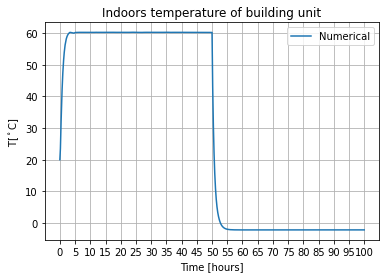

In [13]:
from scipy.integrate import odeint

K = 273.15
dt = 60*60
simTime = 100*dt
tolerance = 1e-5

tSimArray=np.arange(0,simTime,1)
y0 = 20+K
Toutside = -2.2 +K
numericalModel = model(simTime=simTime, WithFur=False)
sol = odeint(numericalModel.buildingModel, y0, tSimArray, args=(Toutside, ),rtol=tolerance,atol=tolerance)
# d = {"Time [hours]": tSimArray/(dt), "T[$^\circ$C]": sol.squeeze()-K}
# df = pd.DataFrame(d)

# sns.set_style("darkgrid")
# sns.lineplot(x='Time [hours]', y='T[$^\circ$C]', data=df, ci=None)
plt.grid()
plt.xticks(np.arange((min(tSimArray)/dt)-5,(max(tSimArray)/dt)+5,5))
#plt.plot(tSimArray[:3600]/(dt), sol[:3600]-K)
plt.plot(tSimArray/dt, sol-K, label="Numerical")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

plt.show()

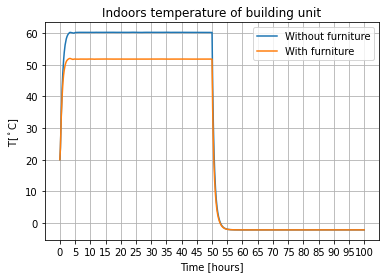

In [14]:
from scipy.integrate import odeint

K = 273.15
dt = 60*60
simTime = 100*dt
tolerance = 1e-5

tSimArray=np.arange(0,simTime,1)
y0 = 20+K
Toutside = -2.2 +K
numericalModel2 = model(simTime=simTime, WithFur=True)
sol2 = odeint(numericalModel2.buildingModel, y0, tSimArray, args=(Toutside, ),rtol=tolerance,atol=tolerance)

plt.grid()
plt.xticks(np.arange((min(tSimArray)/dt)-5,(max(tSimArray)/dt)+5,5))
#plt.plot(tSimArray[:3600]/(dt), sol[:3600]-K)
plt.plot(tSimArray/dt, sol-K, label="Without furniture")
plt.plot(tSimArray/dt, sol2-K, label="With furniture")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

In [ ]:


#%% Analytical
analyticalModel = model()

K = 273.15
y0 = 20 + K
Toutside = -2.2+K
dtAna = 60*60
simTime = 100*dtAna
tAna=np.arange(0,simTime,1)
tf = 50*dtAna

#analyticalResults= analyticalModel.analytical(tAna, T0=y0, k1Init=0.46,tf=tf, T0Change=52.5+K, Toutside=Toutside)
analyticalResultsReal = analyticalModel.analytical(tAna, T0=y0, tf=tf, Toutside=Toutside,T0Change=52.5+K, realValues=True)    
plt.xticks(np.arange((min(t)/dtAna)-5,(max(t)/dtAna)+5,5))
#plt.plot(tAna/dtAna, analyticalResults -K, label="Example values")
plt.plot(tAna/dtAna, analyticalResultsReal - K, label="Real values")
plt.title("Analytical results")
plt.legend()
plt.grid()
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.show()

#%% Test from article
import pandas as pd
df = pd.read_csv("data/articleData.csv", names=['Time [hours]', '[$^\circ$C]'])
print(df.keys())

x = df['Time [hours]']
y = df['[$^\circ$C]']

plt.grid()
plt.xticks(np.arange((min(tSimArray)/dt)-5,(max(tSimArray)/dt)+5,5))
plt.plot(tSimArray/dt, basicSol-K, label="Basic Numerical model")
plt.plot(x,y, label="Article results")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.legend()
plt.title("Indoors temperature of building unit")
plt.show()
# %%
plt.grid()
plt.xticks(np.arange((min(t)/dt)-5,(max(t)/dt)+5,5))
plt.plot(tAna/dtAna, analyticalResultsReal - K, label="Analytical")
plt.plot(t/dt, sol-K, label="Numerical")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.legend()
plt.title("Indoors temperature of building unit")
# %% basic vs dynamic model
from basicNumericalModel import basicModel

K = 273.15
dt = 60*60
simTime = 100*dt
tSimArray=np.arange(0,simTime,1)
y0 = 20+K
Toutside = -2.2 +K
basicNumModel = basicModel(simTime=simTime)
basicSol = odeint(basicNumModel.buildingModel, y0, tSimArray, args=(Toutside, ))
# d = {"Time [hours]": tSimArray/(dt), "T[$^\circ$C]": basicSol.squeeze()-K}
# df = pd.DataFrame(d)

# sns.set_style("darkgrid")
# sns.lineplot(x='Time [hours]', y='T[$^\circ$C]', data=df, ci=None)
plt.grid()
plt.xticks(np.arange((min(tSimArray)/dt)-5,(max(tSimArray)/dt)+5,5))
#plt.plot(tSimArray[:3600]/(dt), basicSol[:3600]-K)
plt.plot(tSimArray/dt, basicSol-K, label="Basic Numerical model")
plt.plot(tSimArray/dt, sol-K, label="Numerical, with furniture")
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.title("Indoors temperature of building unit")
plt.legend()

plt.show()

# %%
analyticalModel = model()

K = 273.15
y0 = 20 + K
Toutside = -2.2+K
dtAna = 60*60
simTime = 100*dtAna
tAna=np.arange(0,simTime,1)
tf = 50*dtAna

#analyticalResults= analyticalModel.analytical(tAna, T0=y0, k1Init=0.46,tf=tf, T0Change=52.5+K, Toutside=Toutside)
analyticalResultsReal = analyticalModel.analytical(tAna, T0=y0, tf=tf, Toutside=Toutside,T0Change=52.5+K, realValues=True)    
plt.xticks(np.arange((min(tAna)/dtAna)-5,(max(tAna)/dtAna)+5,5))
#plt.plot(tAna/dtAna, analyticalResults -K, label="Example values")
plt.plot(tAna/dtAna, analyticalResultsReal - K, label="Analytical")
#plt.plot(tSimArray/dt, basicSol-K, label="Numerical")
plt.title("Analytical vs Numerical results")
plt.legend()
plt.grid()
plt.xlabel('Time [hours]')
plt.ylabel('T[$^\circ$C]')
plt.show()
# %%

plt.plot(np.linspace(0,100,len(model.wallTempLst)),np.array(model.wallTempLst)-K, label="walls")
plt.plot(np.linspace(0,100,len(model.roofTempLst)),np.array(model.roofTempLst)-K, label="roof")
plt.plot(np.linspace(0,100,len(model.floorTempLst)),np.array(model.floorTempLst)-K, label="floor")
plt.plot(np.linspace(0,100,len(model.furTempLst)),np.array(model.furTempLst)-K, label="fur")
plt.legend()
plt.show()
# %%